# Script for Fig. 2F NVS et al. (2021)

In [11]:
import json
import numpy as np
from copy import deepcopy
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import os
from matplotlib import cm
import sys
sys.path.insert(0, '/Users/natvan/CortexControl.app/Contents/MacOS/teili/')

from teili.tools.visualizer.DataViewers import PlotSettings
from teili.tools.visualizer.DataModels import EventsModel, StateVariablesModel
from teili.tools.visualizer.DataControllers import DataController, LineplotController, RasterplotController
from utils_natacha_3 import get_meanfiringrate_from_network_activity,get_network_activity_as_matrix, SpikeEvents, load_recordings_into_spikeevents

DC = DataController()

In [12]:
path_to_recording = '/Users/natvan/CortexControl_Study/rec/TEST/newb/code_updated//111347_OD1_CODE_UPDATED.json'


with open(path_to_recording) as f:    
    recording = json.load(f)
    

column_name = 'column1'
neuron_ids_col1 = list(range(2166, 2234+1))
neuron_ids_col1.remove(2176)
neuron_ids_col1.remove(2177)
neuron_ids_col1.remove(2183)
neuron_ids_col1.remove(2186)
neuron_ids_col1.remove(2204)
neuron_ids_col1.remove(2202)

column_name = 'column5'
neuron_ids_col5 = list(range(2321, 2389+1))
neuron_ids_col5.remove(2337)
neuron_ids_col5.remove(2336)
neuron_ids_col5.remove(2345)
neuron_ids_col5.remove(2326)


column_name = 'column3'
neuron_ids_col3 = list(range(17, 116+1))
neuron_ids_col3.remove(61)
neuron_ids_col3.remove(107)
neuron_ids_col3.remove(90)
neuron_ids_col3.remove(74)
neuron_ids_col3.remove(65)
neuron_ids_col3.remove(47)
neuron_ids_col3.remove(57)


column_name = 'column2'
neuron_ids_col2 = list(range (529,617)) 
neuron_ids_col2.remove(610)
neuron_ids_col2.remove(599)
neuron_ids_col2.remove(594)
neuron_ids_col2.remove(546)
neuron_ids_col2.remove(537)
neuron_ids_col2.remove(532)

column_name = 'column4'
neuron_ids_col4 = list(range (374,463))
neuron_ids_col4.remove(426)
neuron_ids_col4.remove(379)
neuron_ids_col4.remove(438)
neuron_ids_col4.remove(407)
neuron_ids_col4.remove(403)

max_neuron_id = 2389
    

all_column_names = ['column1', 'column2', 'column3', 'column4', 'column5']
all_active_neuron_ids = {'column1': neuron_ids_col1, 'column2': neuron_ids_col2,'column3': neuron_ids_col3, 'column4': neuron_ids_col4, 'column5': neuron_ids_col5}



# create MyEvent-structure per column
network_activity_org = {}
for column_name in all_column_names:
    network_activity_org[column_name] = SpikeEvents(neuron_id=[], ts=[])
    
for event_nr, (neuron_id, spike_time) in enumerate(zip(recording['neuron_ids'], recording['spike_times'])):
    for column_name in all_column_names:
        if neuron_id in all_active_neuron_ids[column_name]:
            network_activity_org[column_name].neuron_id.append(neuron_id)
            network_activity_org[column_name].ts.append(spike_time*(10**-6))

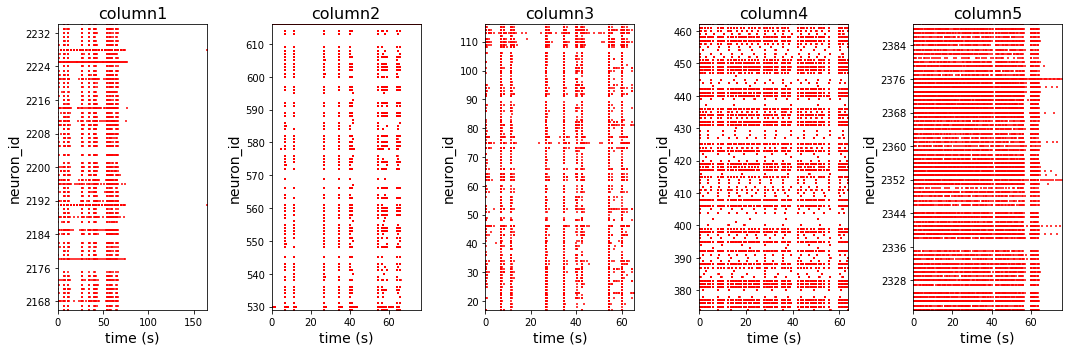

In [13]:
# create rasterplots
fig, (axes) = plt.subplots(ncols=5, nrows=1, figsize=(15,5))
for ax, (column_name, column_events),  in zip(axes, network_activity_org.items()):
    column_neuron_ids = all_active_neuron_ids[column_name]
    eventsmodel  = EventsModel(neuron_ids=column_events.neuron_id, spike_times=column_events.ts)
    RasterplotController([eventsmodel], neuron_id_range=(column_neuron_ids[0], column_neuron_ids[-1]),
                         xlabel='time (s)', ylabel='neuron_id', title=column_name, mainfig=fig,
                         subfig_rasterplot=ax, show_immediately=False)
plt.tight_layout()

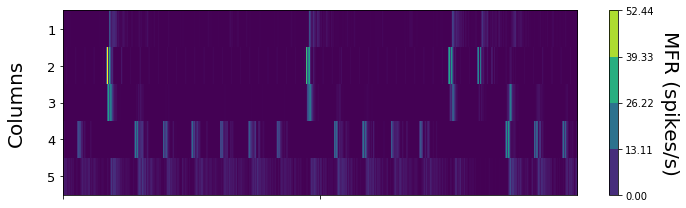

In [14]:
network_activity = deepcopy(network_activity_org)

# filter for time interval & normalize neuron_ids
t_start = 25.  # [s]
t_end   = 45. # [s]
for column_name, column_events in network_activity.items():
    network_activity[column_name].ts, network_activity[column_name].neuron_id = DC.filter_events(all_spike_times=column_events.ts, 
                                                                                         all_neuron_ids=column_events.neuron_id,
                                                                                         interval=(t_start, t_end))
# calculate mfr of population
step_size=0.01
window_size=0.05
get_meanfiringrate_from_network_activity(network_activity=network_activity, max_neuron_id=max_neuron_id,
                                         t_start=t_start, t_end=t_end, step_size=step_size, window_size=window_size,
                                         pop_average=True, active_neuron_ids=all_active_neuron_ids)

# create plot
network_activity_matrix = get_network_activity_as_matrix(network_activity)
mfr_min, mfr_max = np.min(network_activity_matrix), np.max(network_activity_matrix)

fig, (ax) = plt.subplots(nrows=1, figsize=(10,3))
img = ax.imshow(network_activity_matrix, aspect='auto', vmin=mfr_min, vmax=mfr_max)
#cmap=cm.inferno)# vmin=mfr_min, vmax=mfr_max)

ax.set_ylabel('Columns', size = 20, labelpad= 21)
#ax.set_xlabel('None', size = 17)

time_points = network_activity[list(network_activity.keys())[0]].t_mfr[:,0]
ax.set_xticks(range(0, len(time_points), 1000))
ax.set_xticklabels(time_points[::1000])
ax.set_xticklabels([])

ax.set_yticks(range(0, len(network_activity.keys())))
ax.set_yticklabels(['1', '2', '3', '4', '5'])

cbar = plt.colorbar(img, ax=ax, boundaries=np.linspace(mfr_min, mfr_max,5))
cbar.set_label('MFR (spikes/s)', rotation=270, size = 20, labelpad= 25)
plt.xticks(size = 13)
plt.yticks(size = 13)

plt.tight_layout()
plt.show()
#plt.savefig('FIG8C.pdf')